# Introduction

In this notebook we're going to quickly explore the dataset and then train a CNN to recognize the subspecies and the health status of the bees.

* [Read Data](#section-one)
    - [Data Exploration](#subsection-one-one)
* [Data Preparation](#section-two)
* [CNN for subspecies classification](#section-three)
    - [Step 1](#subsection-three-one)
    - [Step 2](#subsection-three-two)
    - [Step 3](#subsection-three-three)
    - [Step 4](#subsection-three-four)
* [CNN for health condition classification](#section-four)
    - [Step 1](#subsection-four-one)
    - [Step 2](#subsection-four-two)
* [Conclusions](#section-five)


In [1]:
# Import libraries

import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras import layers
from keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing
import imageio
import skimage

img_folder='../input/bee_imgs/bee_imgs/'
img_width=100
img_height=100
img_channels=3

<a id="section-one"></a>
# 1. Read Data

In [2]:
# Import data
data=pd.read_csv('../input/honey-bee-annotated-images/bee_data.csv', 
                dtype={'subspecies':'category', 'health':'category','caste':'category'})

# Filter the data
data = data[data.subspecies != "-1"]

data.sample(10).head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
1168,011_018.png,8/19/18,18:30,"Des Moines, IA, USA",50315,Carniolan honey bee,healthy,False,worker
3516,015_1151.png,8/6/18,13:19,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
4691,019_1031.png,8/6/18,19:19,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
408,022_375.png,8/10/18,13:54,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
3417,015_1142.png,8/6/18,13:19,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker


<a id="subsection-one-one"></a>
## 1.1 Data Exploration

### First plot some random images

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


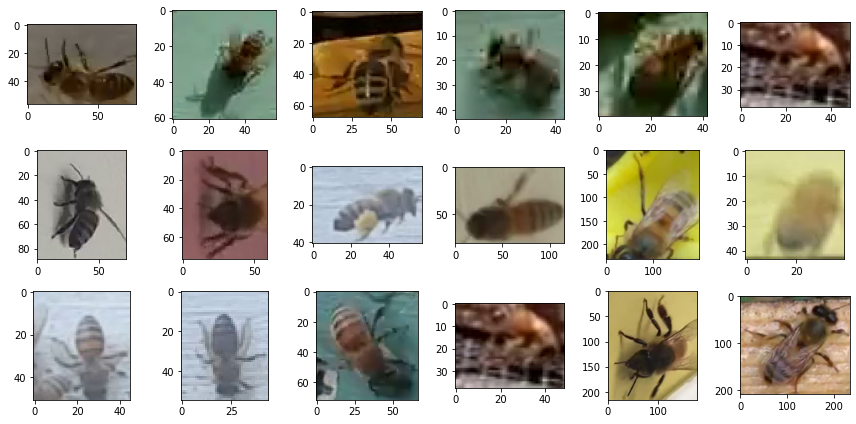

In [3]:
f, ax = plt.subplots(nrows=3,ncols=6, figsize=(2*6,2*3))
for i in range(0,3):
    sample = data.sample(6)
    for j in range(0,6):
        file='../input/honey-bee-annotated-images/bee_imgs/bee_imgs/' + sample.iloc[j]['file']
        im=imageio.imread(file)
        ax[i, j].imshow(im, resample=True)
plt.tight_layout()
plt.show()

### Check if there are some NULL

In [4]:
print(data.isnull().sum())

file               0
date               0
time               0
location           0
zip code           0
subspecies         0
health             0
pollen_carrying    0
caste              0
dtype: int64


### Then check if every instance has a corresponding image

In [5]:
images_list = list(os.listdir('../input/honey-bee-annotated-images/bee_imgs/bee_imgs/'))
print("Number of images:", str(len(images_list)))
file_names = list(data['file'])
intersection = set(file_names).intersection(images_list)
print("Length of intersection between file names and images:", str(len(intersection)))

Number of images: 5172
Length of intersection between file names and images: 4744


### Now plot the categories distributions

<Figure size 432x288 with 0 Axes>

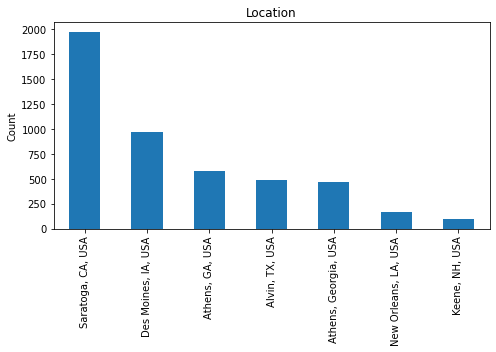

In [6]:
# LOCATION

fig = plt.figure()  
fig, ax = plt.subplots(figsize=(7, 5))
data.location.value_counts().plot(kind='bar', ax=ax)
ax.set_title('Location')
ax.set_ylabel('Count')
fig.tight_layout()
plt.show()

<font size="4">We can see that there's an error: 'Athens, Georgia' and 'Athens, GA' are the same thing, let's correct the dataset: </font>

<Figure size 432x288 with 0 Axes>

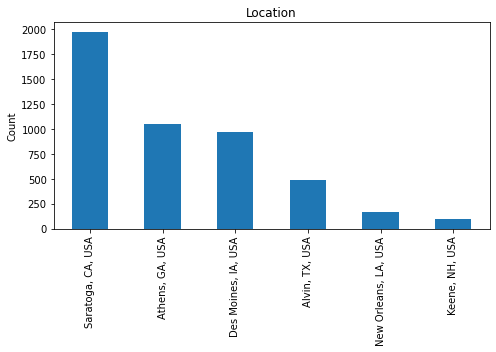

In [7]:
# Correction
data = data.replace({'location':'Athens, Georgia, USA'}, 'Athens, GA, USA')

# Now plot again
fig = plt.figure()  
fig, ax = plt.subplots(figsize=(7, 5))
data.location.value_counts().plot(kind='bar', ax=ax)
ax.set_title('Location')
ax.set_ylabel('Count')
fig.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

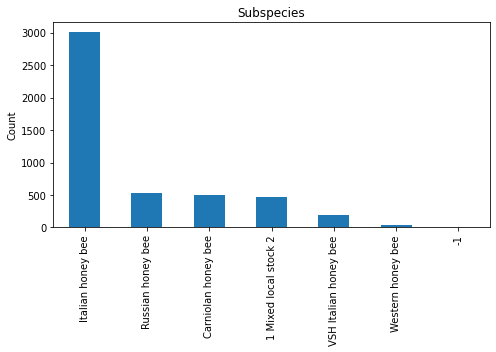

In [8]:
# SUBSPECIES
#data = data[data.subspecies != "-1"]

fig = plt.figure()  
fig, ax = plt.subplots(figsize=(7, 5))
data.subspecies.value_counts().plot(kind='bar', ax=ax)
ax.set_ylabel('Count')
ax.set_title('Subspecies')
fig.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

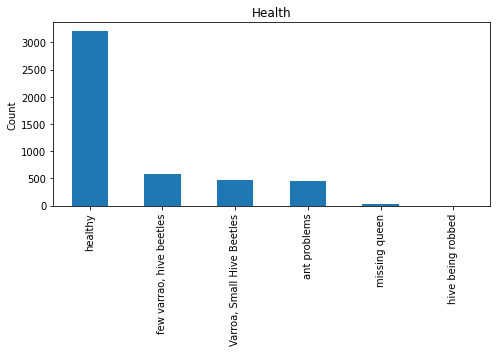

In [9]:
# HEALTH

fig = plt.figure()  
fig, ax = plt.subplots(figsize=(7, 5))
data.health.value_counts().plot(kind='bar', ax=ax)
ax.set_title('Health')
ax.set_ylabel('Count')
fig.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

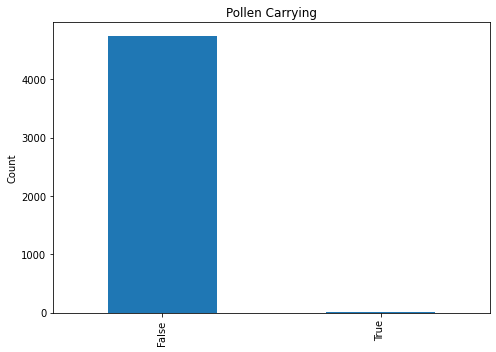

In [10]:
# POLLEN CARRYING

fig = plt.figure()  
fig, ax = plt.subplots(figsize=(7, 5))
data.pollen_carrying.value_counts().plot(kind='bar', ax=ax)
ax.set_title('Pollen Carrying')
ax.set_ylabel('Count')
fig.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

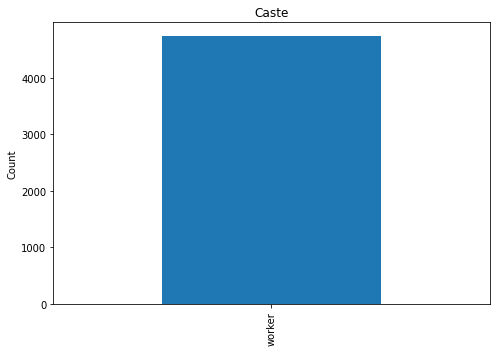

In [11]:
# CASTE 

fig = plt.figure()  
fig, ax = plt.subplots(figsize=(7, 5))
data.caste.value_counts().plot(kind='bar', ax=ax)
ax.set_title('Caste')
ax.set_ylabel('Count')
fig.tight_layout()
plt.show()

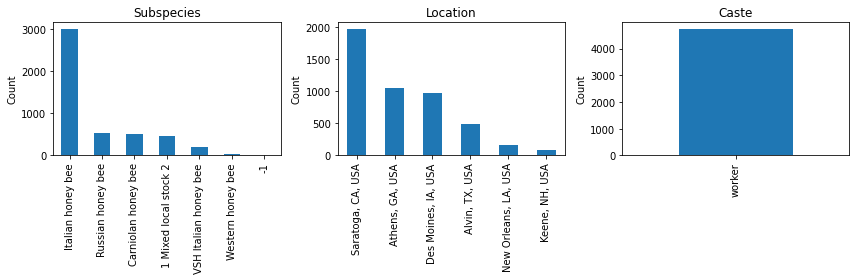

In [12]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
data.subspecies.value_counts().plot(kind='bar',ax=ax[0])
ax[0].set_ylabel('Count')
ax[0].set_title('Subspecies')
data.location.value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_title('Location')
ax[1].set_ylabel('Count')
data.caste.value_counts().plot(kind='bar', ax=ax[2])
ax[2].set_title('Caste')
ax[2].set_ylabel('Count')

f.subplots_adjust(hspace=0.7)
f.tight_layout()
plt.show()

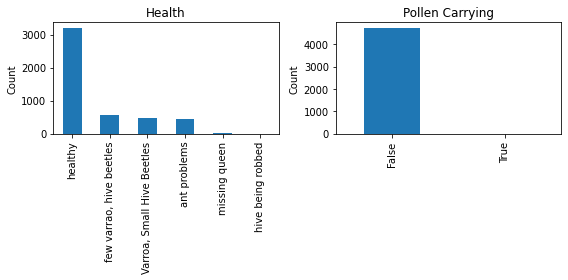

In [13]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
data.health.value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_title('Health')
ax[0].set_ylabel('Count')
data.pollen_carrying.value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_title('Pollen Carrying')
ax[1].set_ylabel('Count')

f.subplots_adjust(hspace=0.7)
f.tight_layout()
plt.show()

<a id="section-two"></a>
# 2. Data Preparation

In [14]:
# Utils functions

def get_img(file_name):   
    img = skimage.io.imread('../input/honey-bee-annotated-images/bee_imgs/bee_imgs/' + file_name)
    # Resize the image so they all have the same dimensions
    img = skimage.transform.resize(img, (100,100))
    return img[:,:,:3]

def get_labels(data, category):
    # The categorical cross-entropy loss class wants labels in a one-hot encoding format
    return pd.get_dummies(data[category], drop_first=False)

In [15]:
data = data[['file', 'subspecies', 'health']]
train_XX, test_XX = train_test_split(data, random_state=42)
train_XX, val_XX = train_test_split(train_XX, test_size=0.1, random_state=42)

# get images and labels
train_X = np.array([get_img(t) for t in train_XX['file']])
train_y = get_labels(train_XX, 'subspecies')

val_X = np.array([get_img(t) for t in val_XX['file']])
val_y = get_labels(val_XX, 'subspecies')

test_X = np.array([get_img(t) for t in test_XX['file']])
test_y = get_labels(test_XX, 'subspecies')

<a id="section-three"></a>
# 3. CNN for subspecies classification
<a id="subsection-three-one"></a>
## 3.1 Step 1
#### Let's start from a very simple architecture. Define and train the model:

In [16]:
model1 = Sequential([
    layers.Conv2D(2, kernel_size=3, input_shape=(100,100,3), activation='relu', padding='same'),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(train_y.columns.size, activation='softmax') # output size equal to the number of possible labels
])

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
training1 = model1.fit(train_X, train_y, epochs=80,
                     validation_data=(val_X, val_y))

2023-01-08 16:03:00.657061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 16:03:00.852100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 16:03:00.852990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 16:03:00.854567: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/80


2023-01-08 16:03:05.645545: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


101/101 [==============================] - 8s 8ms/step - loss: 1.2926 - accuracy: 0.6430 - val_loss: 0.7824 - val_accuracy: 0.7051
Epoch 2/80
101/101 [==============================] - 0s 5ms/step - loss: 0.6204 - accuracy: 0.7414 - val_loss: 0.6496 - val_accuracy: 0.7191
Epoch 3/80
101/101 [==============================] - 0s 5ms/step - loss: 0.5238 - accuracy: 0.7567 - val_loss: 0.6318 - val_accuracy: 0.7612
Epoch 4/80
101/101 [==============================] - 0s 5ms/step - loss: 0.4659 - accuracy: 0.8004 - val_loss: 0.6027 - val_accuracy: 0.7360
Epoch 5/80
101/101 [==============================] - 0s 5ms/step - loss: 0.4320 - accuracy: 0.8079 - val_loss: 0.5840 - val_accuracy: 0.7303
Epoch 6/80
101/101 [==============================] - 0s 5ms/step - loss: 0.4024 - accuracy: 0.8307 - val_loss: 0.5687 - val_accuracy: 0.7584
Epoch 7/80
101/101 [==============================] - 0s 5ms/step - loss: 0.3826 - accuracy: 0.8373 - val_loss: 0.5589 - val_accuracy: 0.8034
Epoch 8/80
101/10

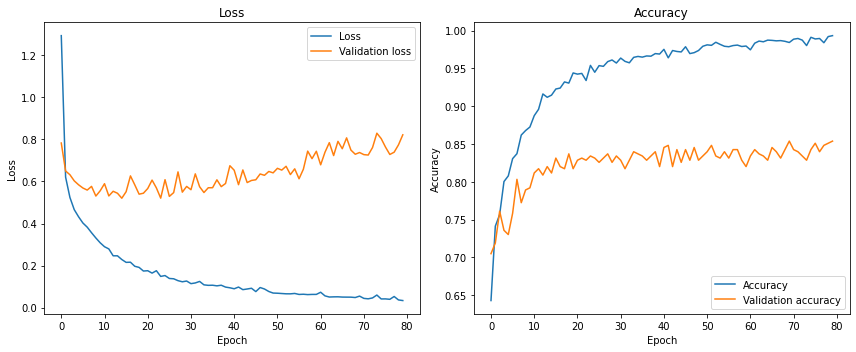

In [17]:
f, ax = plt.subplots(1,2,figsize=(12,5))

# Loss
ax[0].plot(training1.history['loss'], label="Loss")
ax[0].plot(training1.history['val_loss'], label="Validation loss")
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
    
# Accuracy
ax[1].plot(training1.history['accuracy'], label="Accuracy")
ax[1].plot(training1.history['val_accuracy'], label="Validation accuracy")
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

#### Evaluate Model:

In [18]:
score = model1.evaluate(test_X, test_y, verbose=0)
print("Test loss: %.2f " % (score[0]))
print("Test accuracy: %.2f %%" % (score[1]*100))

Test loss: 0.52 
Test accuracy: 86.42 %


<a id="subsection-three-two"></a>
## 3.2 Step 2
#### In the end the losses start to diverge, this is a sign that the model is overfitting so I'll add some data augmentation

In [19]:
model2 = Sequential([
    preprocessing.RandomFlip(mode='horizontal_and_vertical'), 
    preprocessing.RandomRotation((-0.2,0.2), fill_mode="reflect",), 
    preprocessing.RandomContrast(0.5), 
    preprocessing.RandomTranslation((-0.2,0.2), # height factor 
                                    (-0.2,0.2), # width factor
                                    fill_mode="reflect"),
    layers.Conv2D(2, kernel_size=3, input_shape=(100,100,3), activation='relu', padding='same'),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(train_y.columns.size, activation='softmax')
])

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
training2 = model2.fit(train_X, train_y, epochs=50,
                     validation_data=(val_X, val_y))

Epoch 1/50
101/101 [==============================] - 2s 10ms/step - loss: 1.4864 - accuracy: 0.5662 - val_loss: 1.1841 - val_accuracy: 0.6124
Epoch 2/50
101/101 [==============================] - 1s 8ms/step - loss: 0.9408 - accuracy: 0.6755 - val_loss: 0.7587 - val_accuracy: 0.7107
Epoch 3/50
101/101 [==============================] - 1s 8ms/step - loss: 0.7808 - accuracy: 0.7289 - val_loss: 0.7487 - val_accuracy: 0.7669
Epoch 4/50
101/101 [==============================] - 1s 8ms/step - loss: 0.7457 - accuracy: 0.7314 - val_loss: 0.7322 - val_accuracy: 0.6854
Epoch 5/50
101/101 [==============================] - 1s 8ms/step - loss: 0.7489 - accuracy: 0.7395 - val_loss: 0.7262 - val_accuracy: 0.7444
Epoch 6/50
101/101 [==============================] - 1s 8ms/step - loss: 0.7162 - accuracy: 0.7548 - val_loss: 0.6843 - val_accuracy: 0.7893
Epoch 7/50
101/101 [==============================] - 1s 8ms/step - loss: 0.6923 - accuracy: 0.7817 - val_loss: 0.6707 - val_accuracy: 0.7809
Epoch

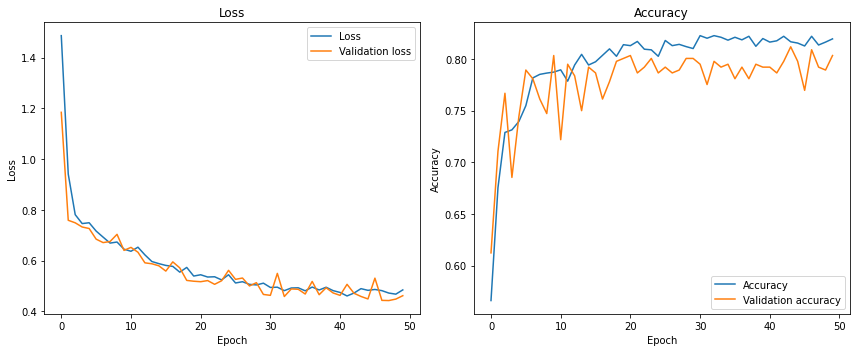

In [20]:
f, ax = plt.subplots(1,2,figsize=(12,5))

# Loss
ax[0].plot(training2.history['loss'], label="Loss")
ax[0].plot(training2.history['val_loss'], label="Validation loss")
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
    
# Accuracy
ax[1].plot(training2.history['accuracy'], label="Accuracy")
ax[1].plot(training2.history['val_accuracy'], label="Validation accuracy")
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [21]:
score = model2.evaluate(test_X, test_y, verbose=0)
print("Test loss: %.2f " % (score[0]))
print("Test accuracy: %.2f %%" % (score[1]*100))

Test loss: 0.40 
Test accuracy: 83.56 %


<a id="subsection-three-three"></a>
## 3.3 Step 3
#### Now I'm starting to add some complexoty to the architecture. Define and train the model:

In [22]:
model3 = Sequential([
    preprocessing.RandomFlip(mode='horizontal_and_vertical'), 
    preprocessing.RandomRotation((-0.2,0.2), fill_mode="reflect",), 
    layers.Conv2D(3, kernel_size=3, input_shape=(100,100,3), activation='relu', padding='same'),
    layers.MaxPool2D(2),
    layers.Conv2D(9, kernel_size=3, input_shape=(100,100,3), activation='relu', padding='same'),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(train_y.columns.size, activation='softmax')
])

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
training3 = model3.fit(train_X, train_y, epochs=50,
                     validation_data=(val_X, val_y))

Epoch 1/50
101/101 [==============================] - 2s 9ms/step - loss: 0.9551 - accuracy: 0.6889 - val_loss: 0.7519 - val_accuracy: 0.7079
Epoch 2/50
101/101 [==============================] - 1s 7ms/step - loss: 0.6878 - accuracy: 0.7577 - val_loss: 0.6426 - val_accuracy: 0.7528
Epoch 3/50
101/101 [==============================] - 1s 6ms/step - loss: 0.6369 - accuracy: 0.7533 - val_loss: 0.6171 - val_accuracy: 0.7219
Epoch 4/50
101/101 [==============================] - 1s 6ms/step - loss: 0.5950 - accuracy: 0.7751 - val_loss: 0.5880 - val_accuracy: 0.7809
Epoch 5/50
101/101 [==============================] - 1s 7ms/step - loss: 0.5445 - accuracy: 0.7898 - val_loss: 0.5220 - val_accuracy: 0.7725
Epoch 6/50
101/101 [==============================] - 1s 7ms/step - loss: 0.5082 - accuracy: 0.8051 - val_loss: 0.5061 - val_accuracy: 0.7893
Epoch 7/50
101/101 [==============================] - 1s 6ms/step - loss: 0.4912 - accuracy: 0.8123 - val_loss: 0.4699 - val_accuracy: 0.8118
Epoch 

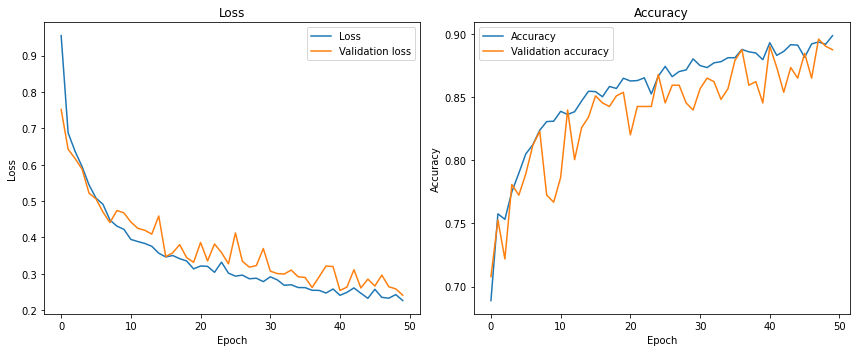

In [23]:
f, ax = plt.subplots(1,2,figsize=(12,5))

# Loss
ax[0].plot(training3.history['loss'], label="Loss")
ax[0].plot(training3.history['val_loss'], label="Validation loss")
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
    
# Accuracy
ax[1].plot(training3.history['accuracy'], label="Accuracy")
ax[1].plot(training3.history['val_accuracy'], label="Validation accuracy")
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [24]:
score = model3.evaluate(test_X, test_y, verbose=0)
print("Test loss: %.2f " % (score[0]))
print("Test accuracy: %.2f %%" % (score[1]*100))

Test loss: 0.22 
Test accuracy: 89.38 %


<a id="subsection-three-four"></a>
## 3.4 Step 4
#### Increase even more the complexity, trying to add more layers, an early stopping callback and a dropout layer. Define and train the model:

In [25]:
model4 = Sequential([
    preprocessing.RandomFlip(mode='horizontal_and_vertical'), 
    preprocessing.RandomRotation((-0.2,0.2), fill_mode="reflect",), 
    layers.Conv2D(3, kernel_size=3, input_shape=(100,100,3), activation='relu', padding='same'),
    #layers.AvgPool2D(2),
    layers.MaxPool2D(2),
    layers.Conv2D(9, kernel_size=3, input_shape=(100,100,3), activation='relu', padding='same'),
    #layers.AvgPool2D(2),
    layers.MaxPool2D(2),
    layers.Conv2D(27, kernel_size=3, input_shape=(100,100,3), activation='relu', padding='same'),
    #layers.AvgPool2D(2),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(56, activation='relu'),
    #layers.Dropout(0.1),
    #layers.Dense(28, activation='relu'),
    layers.Dense(14, activation='relu'),
    layers.Dense(train_y.columns.size, activation='softmax')
])

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
es = EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=1, restore_best_weights=True)
training4 = model4.fit(train_X, train_y, epochs=80,
                     validation_data=(val_X, val_y), callbacks=[es])

Epoch 1/80
101/101 [==============================] - 2s 11ms/step - loss: 1.1065 - accuracy: 0.6315 - val_loss: 0.8762 - val_accuracy: 0.6208
Epoch 2/80
101/101 [==============================] - 1s 9ms/step - loss: 0.6932 - accuracy: 0.7445 - val_loss: 0.5798 - val_accuracy: 0.7135
Epoch 3/80
101/101 [==============================] - 1s 7ms/step - loss: 0.5480 - accuracy: 0.7858 - val_loss: 0.5469 - val_accuracy: 0.7809
Epoch 4/80
101/101 [==============================] - 1s 7ms/step - loss: 0.4146 - accuracy: 0.8426 - val_loss: 0.5417 - val_accuracy: 0.7809
Epoch 5/80
101/101 [==============================] - 1s 7ms/step - loss: 0.3640 - accuracy: 0.8551 - val_loss: 0.4994 - val_accuracy: 0.7500
Epoch 6/80
101/101 [==============================] - 1s 8ms/step - loss: 0.3868 - accuracy: 0.8485 - val_loss: 0.3456 - val_accuracy: 0.8427
Epoch 7/80
101/101 [==============================] - 1s 7ms/step - loss: 0.3279 - accuracy: 0.8716 - val_loss: 0.2855 - val_accuracy: 0.8736
Epoch

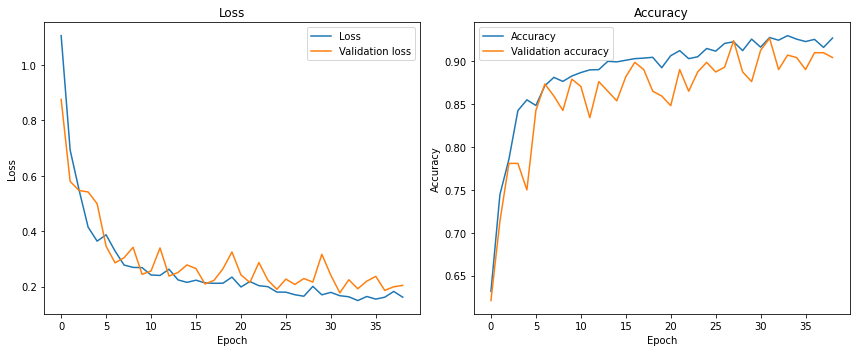

In [26]:
f, ax = plt.subplots(1,2,figsize=(12,5))

# Loss
ax[0].plot(training4.history['loss'], label="Loss")
ax[0].plot(training4.history['val_loss'], label="Validation loss")
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
    
# Accuracy
ax[1].plot(training4.history['accuracy'], label="Accuracy")
ax[1].plot(training4.history['val_accuracy'], label="Validation accuracy")
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [27]:
score = model4.evaluate(test_X, test_y, verbose=0)
print("Test loss: %.2f " % (score[0]))
print("Test accuracy: %.2f %%" % (score[1]*100))

Test loss: 0.16 
Test accuracy: 93.84 %


<a id="section-four"></a>
# 4. CNN for health condition classification
<a id="subsection-four-one"></a>
## 4.1 Step 1
#### Let's start from the architecture that performed the best in the subspecies classification. Before defining and training the model we have to import the labels (Ys).

In [28]:
# Get new labels
train_y = get_labels(train_XX, 'health')
val_y = get_labels(val_XX, 'health')
test_y = get_labels(test_XX, 'health')

In [29]:
# Define and train the model

model5 = Sequential([
    preprocessing.RandomFlip(mode='horizontal_and_vertical'), 
    preprocessing.RandomRotation((-0.2,0.2), fill_mode="reflect",), 
    layers.Conv2D(3, kernel_size=3, input_shape=(100,100,3), activation='relu', padding='same'),
    layers.MaxPool2D(2),
    layers.Conv2D(9, kernel_size=3, input_shape=(100,100,3), activation='relu', padding='same'),
    layers.MaxPool2D(2),
    layers.Conv2D(27, kernel_size=3, input_shape=(100,100,3), activation='relu', padding='same'),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(56, activation='relu'),
    layers.Dense(14, activation='relu'),
    layers.Dense(train_y.columns.size, activation='softmax')
])

model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
es = EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=1, restore_best_weights=True)
training5 = model5.fit(train_X, train_y, epochs=80,
                     validation_data=(val_X, val_y), callbacks=[es])

Epoch 1/80
101/101 [==============================] - 2s 10ms/step - loss: 1.1496 - accuracy: 0.6696 - val_loss: 1.0942 - val_accuracy: 0.6376
Epoch 2/80
101/101 [==============================] - 1s 7ms/step - loss: 0.9084 - accuracy: 0.6727 - val_loss: 0.8582 - val_accuracy: 0.6376
Epoch 3/80
101/101 [==============================] - 1s 7ms/step - loss: 0.7188 - accuracy: 0.7096 - val_loss: 0.7391 - val_accuracy: 0.6461
Epoch 4/80
101/101 [==============================] - 1s 7ms/step - loss: 0.5921 - accuracy: 0.7645 - val_loss: 0.5649 - val_accuracy: 0.7669
Epoch 5/80
101/101 [==============================] - 1s 7ms/step - loss: 0.5043 - accuracy: 0.7929 - val_loss: 0.6742 - val_accuracy: 0.6966
Epoch 6/80
101/101 [==============================] - 1s 7ms/step - loss: 0.4701 - accuracy: 0.7961 - val_loss: 0.5424 - val_accuracy: 0.7191
Epoch 7/80
101/101 [==============================] - 1s 7ms/step - loss: 0.4220 - accuracy: 0.8229 - val_loss: 0.4510 - val_accuracy: 0.7893
Epoch

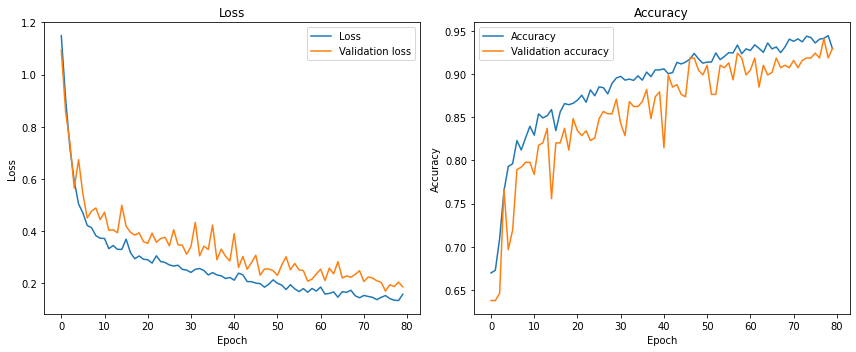

In [30]:
f, ax = plt.subplots(1,2,figsize=(12,5))

# Loss
ax[0].plot(training5.history['loss'], label="Loss")
ax[0].plot(training5.history['val_loss'], label="Validation loss")
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
    
# Accuracy
ax[1].plot(training5.history['accuracy'], label="Accuracy")
ax[1].plot(training5.history['val_accuracy'], label="Validation accuracy")
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [31]:
score = model5.evaluate(test_X, test_y, verbose=0)
print("Test loss: %.2f " % (score[0]))
print("Test accuracy: %.2f %%" % (score[1]*100))

Test loss: 0.16 
Test accuracy: 93.84 %


<a id="subsection-four-two"></a>
## 4.2 Step 2
#### Results are quiet good but can still see some oscillations in the curves; I'll try to add some regularization tp the dense layers.

In [32]:
# Define and train the model

model6 = Sequential([
    preprocessing.RandomFlip(mode='horizontal_and_vertical'), 
    preprocessing.RandomRotation((-0.2,0.2), fill_mode="reflect",), 
    layers.Conv2D(3, kernel_size=3, input_shape=(100,100,3), activation='relu', padding='same'),
    layers.MaxPool2D(2),
    layers.Conv2D(9, kernel_size=3, input_shape=(100,100,3), activation='relu', padding='same'),
    layers.MaxPool2D(2),
    layers.Conv2D(27, kernel_size=3, input_shape=(100,100,3), activation='relu', padding='same'),
    layers.MaxPool2D(2),
    layers.Flatten(),
    # try many settings for regularizers
    layers.Dense(56, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dense(14, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.01)),
    layers.Dense(train_y.columns.size, activation='softmax')
])

model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
es = EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=1, restore_best_weights=True)
training6 = model6.fit(train_X, train_y, epochs=80,
                     validation_data=(val_X, val_y), callbacks=[es])

Epoch 1/80
101/101 [==============================] - 2s 12ms/step - loss: 2.0905 - accuracy: 0.6733 - val_loss: 1.5739 - val_accuracy: 0.6376
Epoch 2/80
101/101 [==============================] - 1s 7ms/step - loss: 1.1854 - accuracy: 0.7220 - val_loss: 0.9448 - val_accuracy: 0.7697
Epoch 3/80
101/101 [==============================] - 1s 9ms/step - loss: 0.8056 - accuracy: 0.7701 - val_loss: 0.7172 - val_accuracy: 0.7697
Epoch 4/80
101/101 [==============================] - 1s 10ms/step - loss: 0.6434 - accuracy: 0.7954 - val_loss: 0.7048 - val_accuracy: 0.7697
Epoch 5/80
101/101 [==============================] - 1s 7ms/step - loss: 0.5933 - accuracy: 0.8136 - val_loss: 0.6204 - val_accuracy: 0.7781
Epoch 6/80
101/101 [==============================] - 1s 8ms/step - loss: 0.5651 - accuracy: 0.8161 - val_loss: 0.6054 - val_accuracy: 0.7921
Epoch 7/80
101/101 [==============================] - 1s 7ms/step - loss: 0.5279 - accuracy: 0.8232 - val_loss: 0.5937 - val_accuracy: 0.8006
Epoc

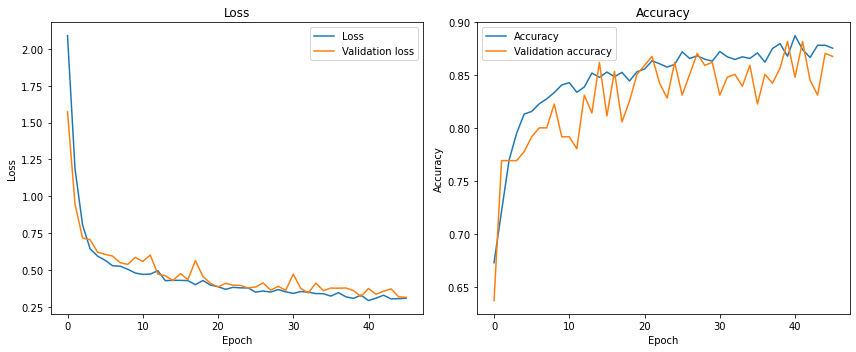

In [33]:
f, ax = plt.subplots(1,2,figsize=(12,5))

# Loss
ax[0].plot(training6.history['loss'], label="Loss")
ax[0].plot(training6.history['val_loss'], label="Validation loss")
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
    
# Accuracy
ax[1].plot(training6.history['accuracy'], label="Accuracy")
ax[1].plot(training6.history['val_accuracy'], label="Validation accuracy")
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [34]:
score = model6.evaluate(test_X, test_y, verbose=0)
print("Test loss: %.2f " % (score[0]))
print("Test accuracy: %.2f %%" % (score[1]*100))

Test loss: 0.31 
Test accuracy: 88.70 %


<a id="section-five"></a>
# 5. Conclusions

#### Results are quite good but we can still see some oscillations in the curves and this is a sign that the model is a bit overfitting. Unfortunately adding some regularization didn't bring any improvements.